#  Прогнозирование заказов такси

**Описание исследования**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.



**Цель исследования**

Спрогнозировать количество заказов такси на следующий час.

**Задача исследования**

Обучить разные модели и выбрать лучшую модель для прогнозирования заказов такси.

Построить модель со значением метрики *RMSE* не больше 48.

**Описание данных**

В CSV-файле столбец `num_orders` содержит количество заказов.

**Данную задачу будем решать в четыре этапа:**

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
4. Проверим данные на тестовой выборке и сделаем выводы.

In [1]:
#загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as sts

from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Подготовка

Загрузим данные:

In [2]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
except:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])

In [3]:
taxi.info()
taxi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Столбец с датами перенесли в индексы, отсортируем даты по возрастанию и выполним ресемплирование по одному часу:

In [4]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()

Проверяем индекс на монотонность

In [5]:
taxi.index.is_monotonic

True

## Анализ

Рассмотрим тренд и сезонность наших данных:

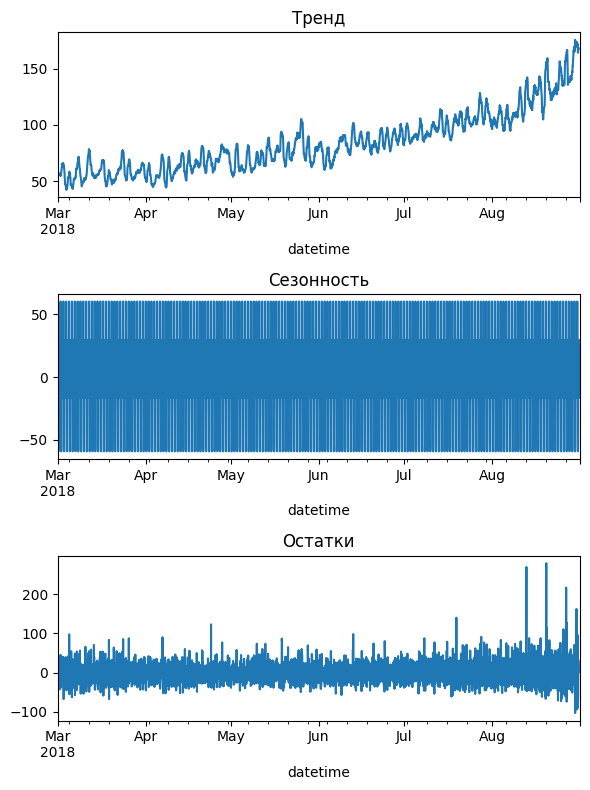

In [6]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

С марта по август плавно увеличивалось количество заказов такси. А сезонность с периодом меньше месяца — исследуем её дальше. Остатки необъяснимы.

Рассмотрим сезонность в период за 2 дня:

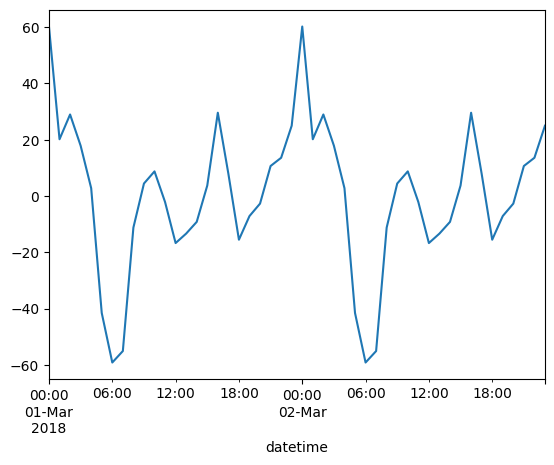

In [7]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot();

Наблюдаем три пика когда клиенты много заказывают такси: в 10 часов, в 17 часов и в полночь. Так же в 6 утра практически нет заказов такси.

Проверяем стационарность ряда (Расширенный тест Дики — Фуллера)

Нулевая гипотеза: ряд не стационарен

Альтернативная: ряд стационарен

In [8]:
test_stat, p_val, _, _, crit_val, _ = sts.adfuller(taxi.num_orders)

In [9]:
test_stat

-3.0689242890279536

In [10]:
p_val

0.028940051402613094

In [11]:
crit_val

{'1%': -3.431842162413052,
 '5%': -2.8621993540813637,
 '10%': -2.567120978470452}

p-значение меньше 0.05, значение статистики меньше критических на 5% и 10% уровнях значимости: нулевую гипотезу можно отвергнуть и признать ряд стационарным.

По результатам расширенного теста Дики-Фулера временной ряд будем считать стационарным.

## Обучение

Обучим три линейные модели: Lasso, Ridge, ElasticNet. 

Для каждой модели подберем разные гиперпараметры. Для оценки качества моделей будем применять метрику RMSE, значение которой не должно превышать 48.

Для обучения нам необходимо добавить входные признаки, создадим их на основе информации из даты, добавив столбец с днем, часов и днем недели. Так же добавим столбцы с предыдущими значения за прошлые дни и столбец со скользящим средним, усреднять будем значения за каждый день.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['day'] = data_new.index.day
    data_new['hour'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(24, (max_lag*24) + 1, 24):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_new

taxi_new = make_features(taxi, 6, 24)

Размер тестовой выборки сделаем 10% от общего количества данных:

In [13]:
train, test = train_test_split(taxi_new, shuffle=False, test_size=0.1)
train = train.dropna() 
print(train.shape)
print(test.shape)

(3830, 11)
(442, 11)


In [14]:
X_train=train.drop(['num_orders'], axis=1)
X_test=test.drop(['num_orders'], axis=1)
y_train=train['num_orders']
y_test=test['num_orders']

num_columns = [x for x in taxi_new.columns if x.startswith('lag')] + ['rolling_mean'] #выбираем количественные значения

data_preprocessor = ColumnTransformer(
    [('num', StandardScaler(), num_columns)],
    remainder='passthrough')

pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', Lasso(random_state=RANDOM_STATE))])

In [15]:
param_distributions = [
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': range(1,6)
    },
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': range(1,6)
    },
    {
        'models': [ElasticNet(random_state=RANDOM_STATE)],
        'models__alpha': range(1,6),
        'models__l1_ratio': np.linspace(0, 1, num=10) #10 значений от 0 до 1
        
    }
] 
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=TimeSeriesSplit()
)
randomized_search.fit(X_train, y_train);

In [16]:
print('Лучшая модель и её параметры:\n', randomized_search.best_estimator_) 

y_test_pred = randomized_search.predict(X_test)
print(f'Метрика RMSE для лучшей модели: {abs(randomized_search.best_score_)}')

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['lag_24', 'lag_48', 'lag_72',
                                                   'lag_96', 'lag_120',
                                                   'lag_144',
                                                   'rolling_mean'])])),
                ('models', Lasso(alpha=1, random_state=42))])
Метрика RMSE для лучшей модели: 24.123542230246095


Лучшей моделью стала Lasso с параметром alpha=1. Метрика имеет хорошее значение.

## Тестирование

Посмотрим на результаты других моделей:

In [17]:
cv_results = pd.DataFrame(randomized_search.cv_results_)[['mean_test_score', 'mean_fit_time',
                                                          'mean_score_time', 'param_models', 'params']]
cv_results['mean_test_score'] = cv_results['mean_test_score'] *(-1)
cv_results = cv_results.sort_values(by='mean_test_score')
cv_results['param_models'] = cv_results['param_models'].astype('category')
first = cv_results.groupby('param_models')['mean_test_score'].min()[0]
second = cv_results.groupby('param_models')['mean_test_score'].min()[1]
third = cv_results.groupby('param_models')['mean_test_score'].min()[2]
ff = pd.concat([cv_results.query('mean_test_score == @first'),cv_results.query('mean_test_score == @second')])
pd.concat([ff,cv_results.query('mean_test_score == @third')])

,mean_test_score,mean_fit_time,mean_score_time,param_models,params
0,24.123542,0.011968,0.004987,"Lasso(alpha=1, random_state=42)","{'models__alpha': 1, 'models': Lasso(alpha=1, ..."
1,24.232191,0.011968,0.004787,Ridge(random_state=42),"{'models__alpha': 1, 'models': Ridge(random_st..."
4,24.544182,0.010173,0.004587,ElasticNet(random_state=42),"{'models__l1_ratio': 0.3333333333333333, 'mode..."


Теперь проверим результат метрики для лучшей модели на тестовой выборке:

In [18]:
print(f'Метрика RMSE на тестовой выборке: {mean_squared_error(y_test, y_test_pred, squared=False)}')

Метрика RMSE на тестовой выборке: 41.21685471113557


Модель показала себя хорошо, метрика на тестовой выборке < 48, поэтому по итогу оставляем модель Lasso с параметром alpha=1.

Сверим результат с метрикой для константной модели:

In [19]:
pipe_dummy = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DummyRegressor())])
pipe_dummy.fit(X_train, y_train) 
dummy_pred = pipe_dummy.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {mean_squared_error(y_test, dummy_pred, squared=False)}') 

Метрика RMSE на тестовой выборке: 84.06620644726425


Результат метрики найденной нами модели гораздо лучше, чем результат константной модели.

In [20]:
df = pd.DataFrame(y_test_pred, index=y_test.index, columns=['num_orders_pred'])
df2 = pd.DataFrame(y_test, index=y_test.index)
new = pd.concat([df,df2])

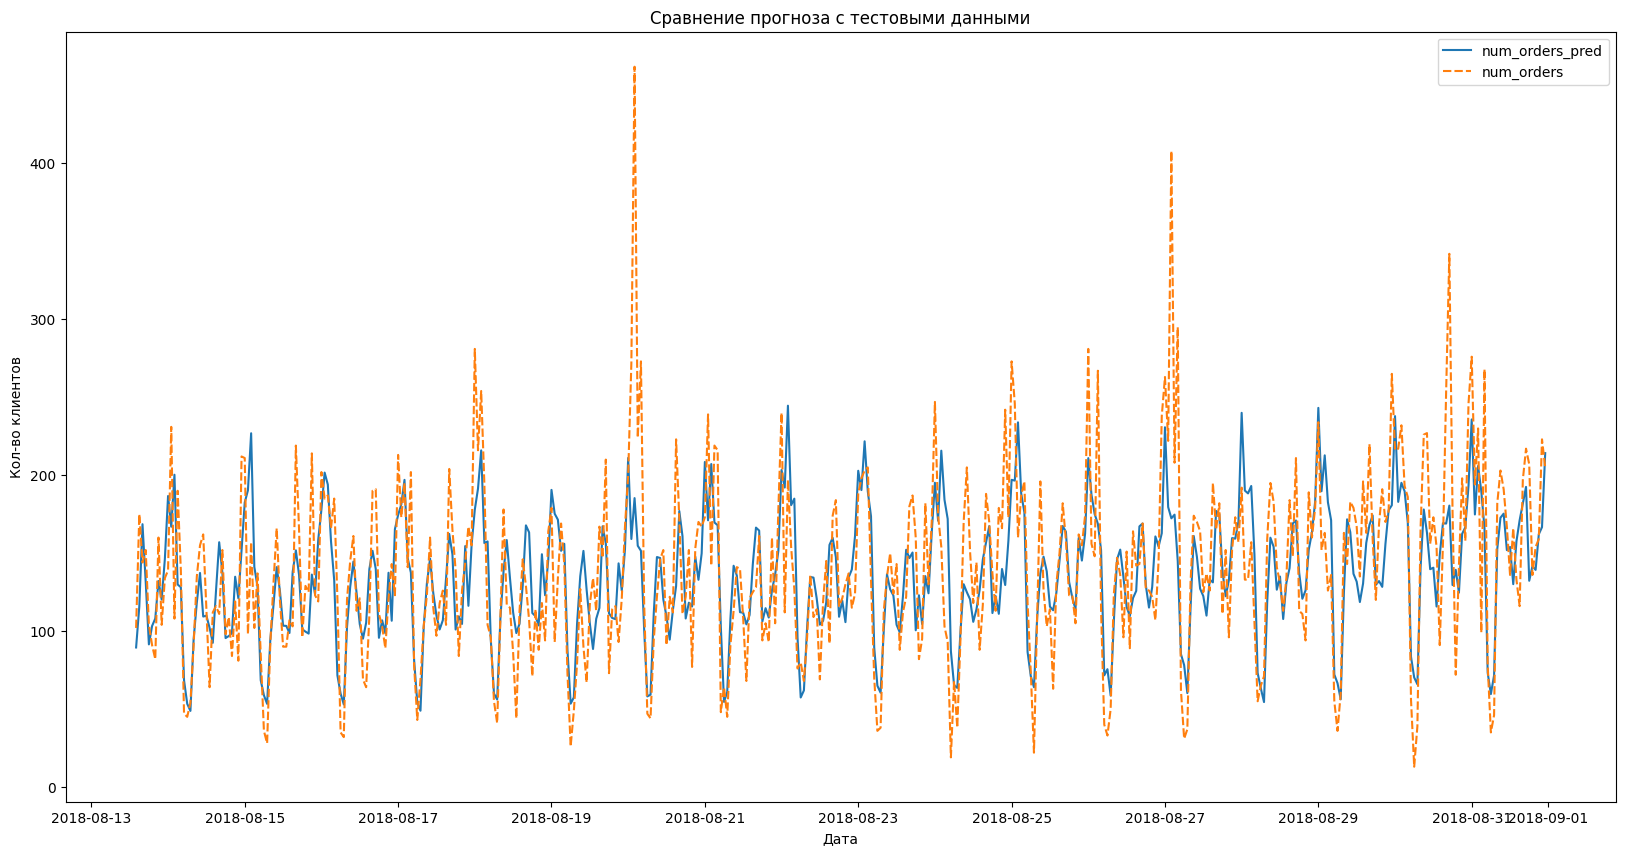

In [21]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=new)
plt.xlabel('Дата')
plt.ylabel('Кол-во клиентов')
plt.title('Сравнение прогноза с тестовыми данными');

Наша модель не учитывает случаи резкого роста клиентов, как например пик в ночь между 19 и 20 августа. В остальном модель показывает довольно точные результаты.

## Общий вывод

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно было построить модель для предсказания количества заказов такси на следующий час.

Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders.

Столбец с датами перенесли в индексы и выполнили ресемплирование по одному часу.

В ходе анализа получили:
- С марта по август плавно увеличивалось количество заказов такси. 
- Клиенты много заказывают такси в 10 часов, в 17 часов и в полночь. Так же в 6 утра практически нет заказов такси.

Для прогнозирования мы обучали три линейные модели: Lasso, Ridge, ElasticNet, с разными гиперпараметрами. Для оценки качества моделей применяли метрику RMSE, значение которой не должно было превышать 48. Размер тестовой выборки составлял 10%.

Для обучения мы добавили входные признаки с днем, часом и днем недели. Так же добавили столбцы с предыдущими значения за прошлые дни и столбец со скользящим средним, усредненным за каждый день.

Лучшей моделью стала Lasso с параметром alpha = 1. Метрика RMSE имела хорошее значение на тренировочных данных = 24.
На тестовой выборке метрика RMSE показала хорошее значение = 41, что меньше требуемого значения = 48.

Результат метрики константной модели на тестовой выборке имела значение = 84, что подтвердило актуальность выбранной нами модели. 

Поэтому лучшей моделью для компании выбрали модель Lasso с параметром alpha = 1.

Мы построили хорошую модель по прогнозированию часовой загруженности таксистов, которая будет устраивать компанию.
Дополнительно можно рассмотреть другие входные признаки, и также другие модели.